### Imports:


In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import joblib
import matplotlib.image as mpimg
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
%matplotlib inline

### HOG feature extraction:

In [2]:
def extract_features(imgs, cspace='RGB', size = (64,64)):
    features = []
    for filename in imgs:
        image = imread(filename)
        if size != (64,64):
            image = cv2.resize(image, size)
        features.append(
            np.ravel(
                cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) \
                    .compute(get_feature_space(image, cspace))
            )
        )
    return features

In [3]:
def get_feature_space(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HLS':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'HSV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'YUV':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'Lab':
            features = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        return features
def get_hog_features(img, cspace):
    return np.ravel(
        cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) \
            .compute(get_feature_space(img, cspace))
    )

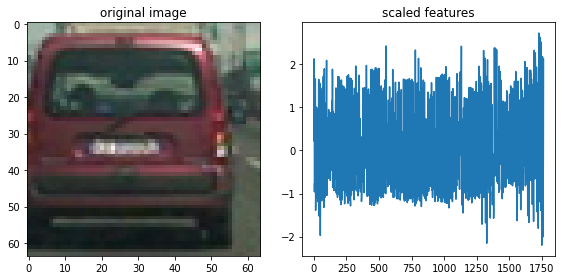

In [4]:

vehicles = glob.glob('Data/vehicles/*/*.png')
non_vehicles = glob.glob('Data/non-vehicles/*/*.png')
vehicle_features = extract_features(vehicles, cspace='YUV')
non_vehicle_features = extract_features(non_vehicles, cspace='YUV')

def plot_features(vehicle_features, non_vehicle_features):
    vehicle_features[0].shape
    if len(vehicle_features) > 0:
        X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64) 
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        vehicle_ind = np.random.randint(0, len(vehicles))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(vehicles[vehicle_ind]))
        plt.title('original image')
        plt.subplot(132)
        plt.plot(scaled_X[vehicle_ind])
        plt.title('scaled features')
        fig.tight_layout()
    return scaled_X, X_scaler
        
scaled_X, X_scaler = plot_features(vehicle_features, non_vehicle_features)  

### splitting dataset

In [6]:
#horizontal stack ones for cars and otherwise zero
labels = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
#20% test images 
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, labels, test_size=0.2, random_state=4000)

__Training model with MLP__


In [7]:
#Multi-layer Perceptron classifier model

mlp = MLPClassifier(random_state=999)
mlp.fit(X_train, y_train)
print('MLP results')
print('accuracy on training data: ', mlp.score(X_train, y_train))
print('accuracy on test data: ', mlp.score(X_test, y_test))
prediction = mlp.predict(X_test[0].reshape(1, -1))

MLP results
accuracy on training data:  1.0
accuracy on test data:  0.9916107382550335


In [8]:
# saving trained data 
joblib.dump(mlp, 'mlp1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')


['scaler1.pkl']

In [9]:
# loading trained data file 
mlp = joblib.load('mlp1.pkl')
X_scaler = joblib.load('scaler1.pkl')

__Sliding Window__

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    if x_start_stop[0] == None: # start from the left
        x_start_stop[0] = 0
    if x_start_stop[1] == None: # stop at the left
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:# start from the bottom
        y_start_stop[0] = 0
    if y_start_stop[1] == None: # stop at the top
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0] # span size horizontally
    yspan = y_start_stop[1] - y_start_stop[0] # span size vertically
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))  #the part of the window without overlapping horizontally
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))  #the part of the window without overlapping vertically
    
    nx_windows = np.int(xspan/nx_pix_per_step) # number of windows horizontally
    
    ny_windows = np.int(yspan/ny_pix_per_step) #number of windows vertically
    window_list = []
    # scan the span from left to right and from top to bottom
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # append the top left and bottom right corner points of each window
            window_list.append(((startx, starty), (endx, endy)))
    return window_list # list of all the window coordinates in the span

### car detection using the sliding window

In [11]:
def annotate_img(path):

    image = imread(path)
    detected_vehicles = [] 
    pxs = 320            # window starting size 
    PXS_LIMIT = 720      # max window size
    y_start_stop = [400, 660]    #search in the lower part of the image to decrease the time 
    xy_overlap = (0.8, 0.8)      #propability of overlapped = 80% 
    ACCEPTANCE_THRESHOLD = .98   # the accuracy = 98% 
    INCREMENT_PXS_BY = 16        #window increasing step 
    while pxs < PXS_LIMIT:       #check if window size is smaller than the max window size
        windows = slide_window(  #call the sliding window function to return list of the windows coordinates 
            image, 
            x_start_stop=[640, None], 
            y_start_stop=y_start_stop, 
            xy_window=(pxs, pxs), 
            xy_overlap=xy_overlap
        )  
        for w in windows: #loop inside the windows list to get the target windows which containg vehicles 
            features = []
            resized = cv2.resize(  # resize the window to (64*64) to get the feature vector 
                (
                    image[w[0][1]: w[1][1], w[0][0]: w[1][0]]
                ),(64,64)
            )
            
            hf = get_hog_features(resized, cspace='YUV')
            x_scaled = X_scaler.transform(hf.reshape(1, -1))
            if resized.shape[0] > 0: #check that the width of the window isnt equal 0 
                if mlp.predict_proba(x_scaled.reshape(1,-1))[0][1] > ACCEPTANCE_THRESHOLD: 
                    #checking if the window feature vector is matching with the model 
                    #then , adding the window to detected_vehicles list  
                    detected_vehicles.append(w)
        pxs += INCREMENT_PXS_BY #finally at the end of the loop increment the window dimensions with 16

###  Draw boxes

In [16]:
from collections import deque
class boxes:
    def __init__(self):
        self.detections = deque(maxlen=12)

In [17]:

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    out_img = np.copy(img)
    for b in bboxes:
        cv2.rectangle(out_img, *b, color, thick)
    return out_img

### car detection using the sliding window for videos 

In [13]:
def process_vid(image):
    
    detected_vehicles = [] 
    pxs = 320            # window starting size 
    PXS_LIMIT = 720      # max window size
    y_start_stop = [400, 660]    #search in the lower part of the image to decrease the time 
    xy_overlap = (0.8, 0.8)      #propability of overlapped = 80% 
    ACCEPTANCE_THRESHOLD = .98   # the accuracy = 98% 
    INCREMENT_PXS_BY = 16        #window increasing step 
    while pxs < PXS_LIMIT:       #check if window size is smaller than the max window size
        windows = slide_window(  #call the sliding window function to return list of the windows coordinates 
            image, 
            x_start_stop=[640, None], 
            y_start_stop=y_start_stop, 
            xy_window=(pxs, pxs), 
            xy_overlap=xy_overlap
        )  
        for w in windows: #loop inside the windows list to get the target windows which containg vehicles 
            features = []
            resized = cv2.resize(  # resize the window to (64*64) to get the feature vector 
                (
                    image[w[0][1]: w[1][1], w[0][0]: w[1][0]]
                ),(64,64)
            )
            
            hf = get_hog_features(resized, cspace='YUV')
            x_scaled = X_scaler.transform(hf.reshape(1, -1))
            if resized.shape[0] > 0: #check that the width of the window isnt equal 0 
                if mlp.predict_proba(x_scaled.reshape(1,-1))[0][1] > ACCEPTANCE_THRESHOLD: 
                    #checking if the window feature vector is matching with the model 
                    #then , adding the window to detected_vehicles list  
                    detected_vehicles.append(w)
        pxs += INCREMENT_PXS_BY #finally at the end of the loop increment the window dimensions with 16 
        
                
    out = np.copy(image).astype('uint8')
    #draw boxes on mask image (black img)
    boxes = draw_boxes( np.zeros_like(image), bboxes=detected_vehicles, thick=-1)
    rects_arr = []
    #get contours of the boxes image 
    contours, _ = cv2.findContours(boxes[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)  #connect contours and draw box around the cars detected 
        rects_arr.append([x, y, x + width, y + height])  
    Boxes.detections.append(rects_arr) #queue of list of all the detected boxes 
    boxes = []
    combined = np.ravel(np.array(Boxes.detections))
    for i in range(len(combined)):
        boxes.extend(np.ravel(combined[i]))
    bb = []
    i = 0
    while i <= len(boxes)-3:
        bb.append(boxes[i:i+4])
        i += 4
    rects, _ = cv2.groupRectangles(np.array(bb).tolist(), 10,.1)
    for r in rects:
        cv2.rectangle(out, (r[0], r[1]), (r[2],r[3]), (0,255,0), 5)
    return out

### Output video

In [19]:
from moviepy.editor import VideoFileClip
Boxes = boxes()
output = 'r.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_vid)
%time clip.write_videofile(output, audio=False)

Moviepy - Building video r.mp4.
Moviepy - Writing video r.mp4



Moviepy - Done !
Moviepy - video ready r.mp4
Wall time: 4min 42s


In [18]:
from moviepy.editor import VideoFileClip
Boxes = boxes()
output = 'challenge2.mp4'
clip1 = VideoFileClip('challenge_video.mp4')
clip = clip1.fl_image(process_vid)
%time clip.write_videofile(output, audio=False)

Moviepy - Building video challenge2.mp4.
Moviepy - Writing video challenge2.mp4



Moviepy - Done !
Moviepy - video ready challenge2.mp4
Wall time: 1min 35s
